In [5]:
%%capture
!pip install pandas numpy matplotlib seaborn plotly tensorflow scikit-learn ipython

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = "F:\\Anomaly_Images\\Train"
test_dir = "F:\\Anomaly_Images\\Test"

SEED = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 10
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','RoadAccidents','Robbery','Shooting','Shoplifting','Snatching','Stealing','Vandalism']

In [18]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [20]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 28879 images belonging to 14 classes.
Found 5612 images belonging to 14 classes.


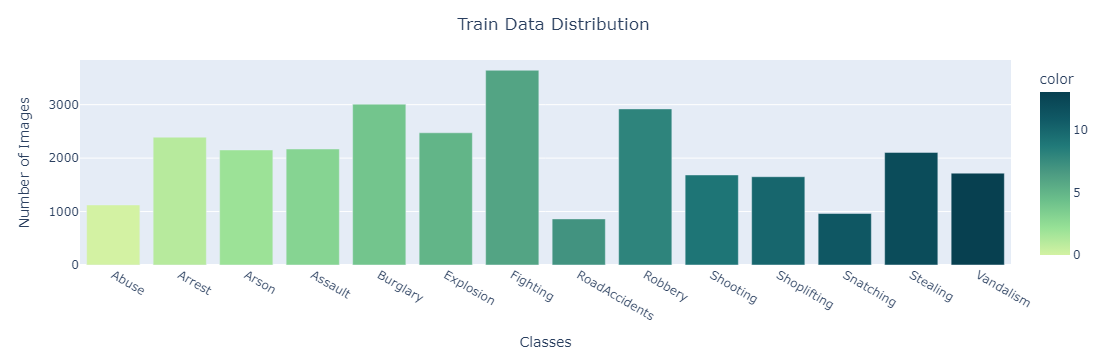

In [22]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

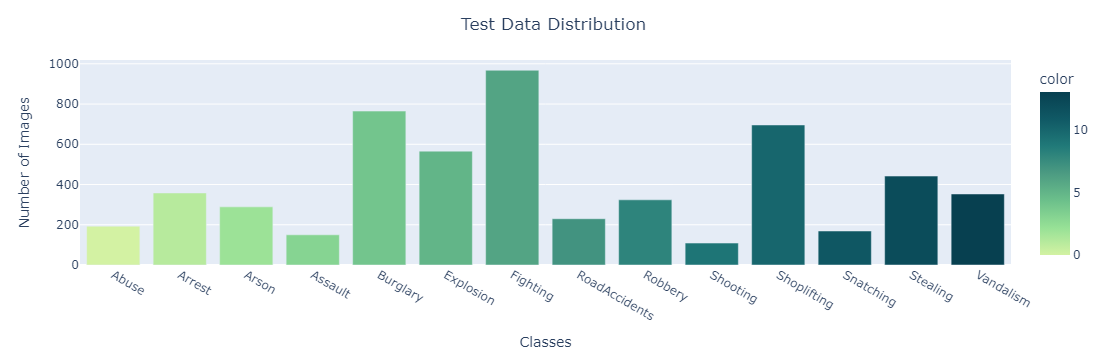

In [24]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [105]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,095,054 (30.88 MB)

 Trainable params: 8,011,406 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [36]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs=EPOCHS)

Epoch 1/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - auc_1: 0.5267 - loss: 2.9327 - val_auc_1: 0.5215 - val_loss: 2.6733
Epoch 2/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 820s 907ms/step - auc_1: 0.5397 - loss: 2.8632 - val_auc_1: 0.5801 - val_loss: 2.6045
Epoch 3/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 849s 939ms/step - auc_1: 0.5537 - loss: 2.8031 - val_auc_1: 0.6186 - val_loss: 2.5535
Epoch 4/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 865s 957ms/step - auc_1: 0.5638 - loss: 2.7740 - val_auc_1: 0.6426 - val_loss: 2.5182
Epoch 5/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 859s 950ms/step - auc_1: 0.5735 - loss: 2.7355 - val_auc_1: 0.6655 - val_loss: 2.4861
Epoch 6/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 858s 950ms/step - auc_1: 0.5839 - loss: 2.7048 - val_auc_1: 0.6806 - val_loss: 2.4612
Epoch 7/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 860s 951ms/step - auc_1: 0.5919 - loss: 2.6801 - val_auc_1: 0.6964 - val_loss: 2.4350
Epoch 8/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 954s 1s/step - auc_1: 0.6021 - loss: 2.6505 - val_auc_1: 0.7073 - val_loss: 2.412

In [119]:
# Save the entire model
model.save('F:\\Model_Saved\\Trained\\ADmodel.h5')
model.save('F:\\Model_Saved\\Trained\\ADmodel.keras')

176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step
ROC AUC score: 0.47725454508027704


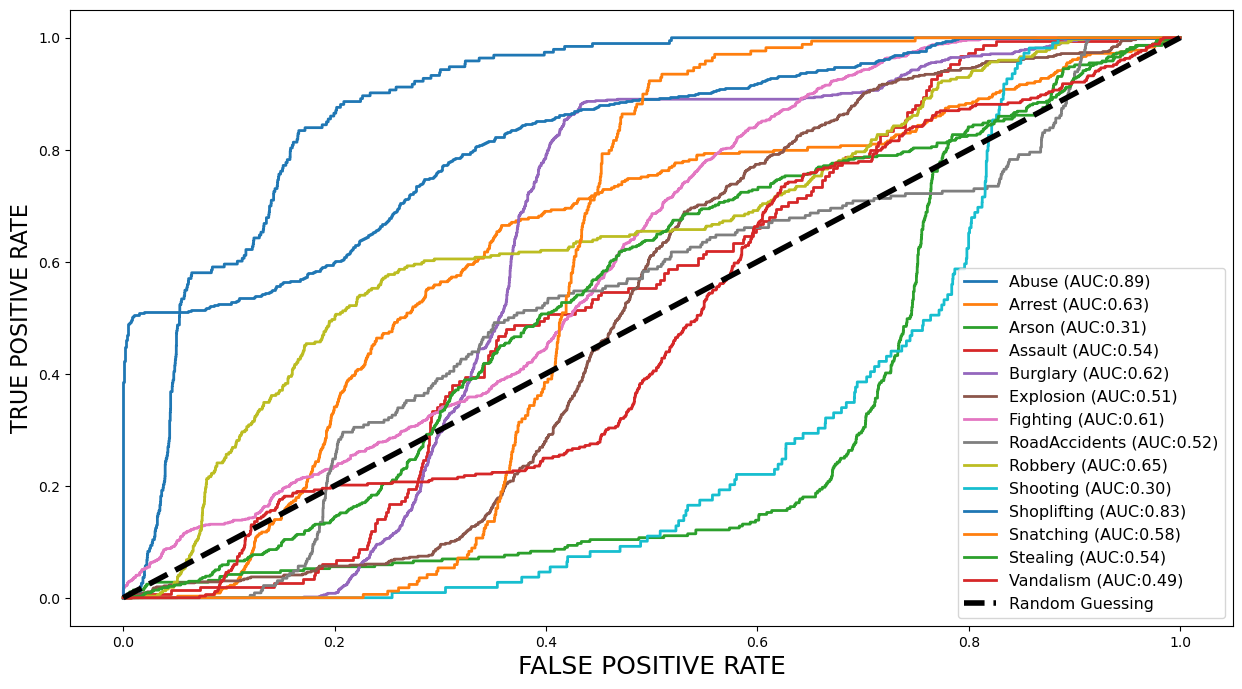

In [107]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()